## Neural networks for segmentation

```
$ wget https://www.dropbox.com/s/jy34yowcf85ydba/data.zip?dl=0 -O data.zip
$ unzip -q data.zip
```

Your next task is to train neural network to segment cells edges.

Here is an example of input data with corresponding ground truth:

This time you aren't provided with any code snippets, just input data and target metric - intersection-over-union (IoU) (see implementation below).

You should train neural network to predict mask of edge pixels (pixels in gt images with value greater than 0).

Use everything you've learnt by now: 
* any architectures for semantic segmentation (encoder-decoder like or based on dilated convolutions)
* data augmentation (you will need that since train set consists of just 41 images)
* fine-tuning

You're not allowed to do only one thing: to train you network on test set.

Your final solution will consist of an ipython notebook with code (for final network training + any experiments with data) and an archive with png images with network predictions for test images (one-channel images, 0 - for non-edge pixels, any non-zero value for edge pixels).

Forestalling questions about baseline... well, let's say that a good network should be able to segment images with iou >= 0.29. This is not a strict criterion of full points solution, but try to obtain better numbers.

Practical notes:
* There is a hard data class imbalance in dataset, so the network output will be biased toward "zero" class. You can either tune the minimal probability threshold for "edge" class, or add class weights to increase the cost of edge pixels in optimized loss.
* Dataset is small so actively use data augmentation: rotations, flip, random contrast and brightness
* Better spend time on experiments with neural network than on postprocessing tricks (i.e test set augmentation).
* Keep in mind that network architecture defines receptive field of pixel. If the size of network input is smaller than receptive field of output pixel, than probably you can throw some layers without loss of quality. It is ok to modify "of-the-shelf" architectures. 

Good luck!

In [1]:
import torchvision
import os
import random
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import time
import torch
from tensorboardX import SummaryWriter
import torchvision.utils as vutils
%matplotlib inline

class SegmentationDataset:
    def __init__(self, img_folder, target_folder, transforms=[]):
        self.dataset = []
        self.transforms = transforms
        for img, target in zip(sorted(os.listdir(img_folder)), sorted(os.listdir(target_folder))):
            img_pil = Image.open(os.path.join(img_folder, img))
            target_pil = Image.open(os.path.join(target_folder, target))
            self.dataset.append((img_pil, target_pil))
            
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, index):
        img, target = self.dataset[index]
        for transform, apply_to_target in self.transforms:
            random_state = random.getstate()
            np_random_state = np.random.get_state()
            img = transform(img)
            if apply_to_target:
                random.setstate(random_state)
                np.random.set_state(np_random_state)
                target = transform(target)
        return img.astype(np.float32) / 255, (target > 0).astype(np.uint8)
    
class ToNumpyArray:
    def __call__(self, img):
        return np.asarray(img).T

In [2]:
train_dataset = SegmentationDataset(
    "BBBC018_v1_images-fixed/train/", "BBBC018_v1_outlines/train/",
    (
        (torchvision.transforms.ColorJitter(0.05, 0.05, 0.05, 0.00), False),
        (torchvision.transforms.RandomHorizontalFlip(), True),
        (torchvision.transforms.RandomVerticalFlip(), True),
        (torchvision.transforms.RandomRotation(90), True),
        (torchvision.transforms.RandomResizedCrop(size=512, scale=(0.5, 1.0), ratio=(0.5, 2)), True),
        (ToNumpyArray(), True)
    )
)

val_dataset = SegmentationDataset("BBBC018_v1_images-fixed/val/", "BBBC018_v1_outlines/val/",
    (
        (ToNumpyArray(), True),
    )
)

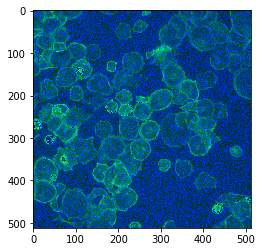

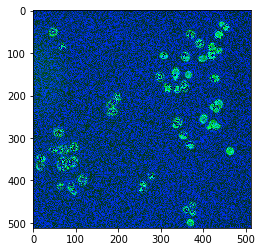

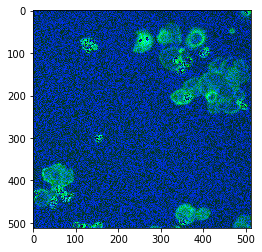

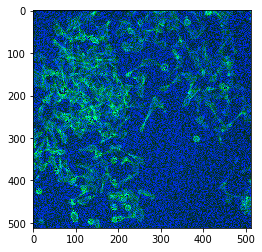

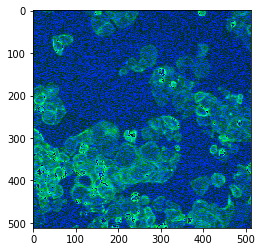

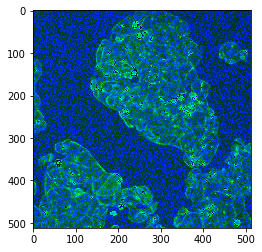

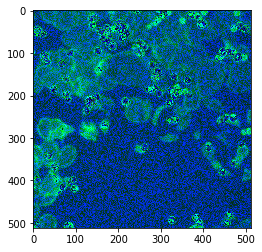

In [3]:
for i in range(7):
    plt.imshow(val_dataset[i][0].T)
    plt.show()

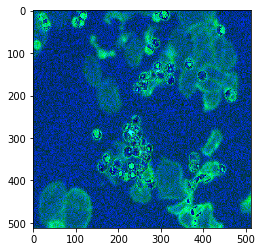

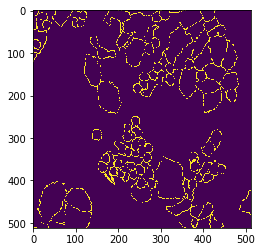

In [4]:
data = train_dataset[40]
plt.imshow((data[0].T))
plt.show()
plt.imshow((data[1].T) > 0)
plt.show()

In [5]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=1, shuffle=False)

In [6]:
class ConvBlock2D(torch.nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, dilation=1):
        super().__init__()
        assert(kernel_size % 2 == 1)
        padding = dilation * (kernel_size - 1) // 2
        self.conv = torch.nn.Conv2d(in_channels, out_channels, kernel_size,
                                    padding=padding, dilation=dilation, bias=False)
        self.bn = torch.nn.BatchNorm2d(out_channels)
        self.activation = torch.nn.ReLU()
    
    def forward(self, x):
        x = self.conv.forward(x)
        x = self.bn.forward(x)
        x = self.activation.forward(x)
        return x
    
class UpConv(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.transpose_conv = torch.nn.ConvTranspose2d(in_channels, out_channels,
                                                      kernel_size=(2, 2), stride=2)
        self.bn = torch.nn.BatchNorm2d(out_channels)
        self.activation = torch.nn.ReLU()
        
    def forward(self, x):
        x = self.transpose_conv.forward(x)
        x = self.bn.forward(x)
        x = self.activation.forward(x)
        return x
    
class UNet(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_l_512_0 = ConvBlock2D(3, 64, kernel_size=3)
        self.conv_l_512_1 = ConvBlock2D(64, 64, kernel_size=3)
        self.max_pool_512_256 = torch.nn.MaxPool2d(kernel_size=(2, 2), stride=2)
        
        self.conv_l_256_0 = ConvBlock2D(64, 128, kernel_size=3)
        self.conv_l_256_1 = ConvBlock2D(128, 128, kernel_size=3)
        self.max_pool_256_128 = torch.nn.MaxPool2d(kernel_size=(2, 2), stride=2)
        
        self.conv_l_128_0 = ConvBlock2D(128, 256, kernel_size=3)
        self.conv_l_128_1 = ConvBlock2D(256, 256, kernel_size=3)
        self.max_pool_128_64 = torch.nn.MaxPool2d(kernel_size=(2, 2), stride=2)
        
        self.conv_l_64_0 = ConvBlock2D(256, 512, kernel_size=3)
        self.conv_l_64_1 = ConvBlock2D(512, 512, kernel_size=3)
        self.max_pool_64_32 = torch.nn.MaxPool2d(kernel_size=(2, 2), stride=2)
        
        self.conv_32_0 = ConvBlock2D(512, 1024, kernel_size=3)
        self.conv_32_1 = ConvBlock2D(1024, 1024, kernel_size=3)
        
        self.upconv_32_64 = UpConv(1024, 512)
        self.conv_r_64_0 = ConvBlock2D(1024, 512, kernel_size=3)
        self.conv_r_64_1 = ConvBlock2D(512, 512, kernel_size=3)
        
        self.upconv_64_128 = UpConv(512, 256)
        self.conv_r_128_0 = ConvBlock2D(512, 256, kernel_size=3)
        self.conv_r_128_1 = ConvBlock2D(256, 256, kernel_size=3)
        
        self.upconv_128_256 = UpConv(256, 128)
        self.conv_r_256_0 = ConvBlock2D(256, 128, kernel_size=3)
        self.conv_r_256_1 = ConvBlock2D(128, 128, kernel_size=3)
        
        self.upconv_256_512 = UpConv(128, 64)
        self.conv_r_512_0 = ConvBlock2D(128, 64, kernel_size=3)
        self.conv_r_512_1 = ConvBlock2D(64, 64, kernel_size=3)
        
        self.final_conv = ConvBlock2D(64, 2, kernel_size=1)
    
    def forward(self, x):
        x1 = self.conv_l_512_0.forward(x)
        x1 = self.conv_l_512_1.forward(x1)
        
        x2 = self.max_pool_512_256.forward(x1)
        x2 = self.conv_l_256_0.forward(x2)
        x2 = self.conv_l_256_1.forward(x2)
        
        x3 = self.max_pool_256_128.forward(x2)
        x3 = self.conv_l_128_0.forward(x3)
        x3 = self.conv_l_128_1.forward(x3)
        
        x4 = self.max_pool_128_64.forward(x3)
        x4 = self.conv_l_64_0.forward(x4)
        x4 = self.conv_l_64_1.forward(x4)
        
        y = self.max_pool_64_32.forward(x4)
        y = self.conv_32_0.forward(y)
        y = self.conv_32_1.forward(y)
        y = self.upconv_32_64.forward(y)
        
        y = self.conv_r_64_0.forward(torch.cat((y, x4), 1))
        y = self.conv_r_64_1.forward(y)
        y = self.upconv_64_128.forward(y)
        
        y = self.conv_r_128_0.forward(torch.cat((y, x3), 1))
        y = self.conv_r_128_1.forward(y)
        y = self.upconv_128_256.forward(y)
        
        y = self.conv_r_256_0.forward(torch.cat((y, x2), 1))
        y = self.conv_r_256_1.forward(y)
        y = self.upconv_256_512.forward(y)
        
        y = self.conv_r_512_0.forward(torch.cat((y, x1), 1))
        y = self.conv_r_512_1.forward(y)
        y = self.final_conv.forward(y)
        
        return y

In [7]:
model = UNet()
model.cuda()
# optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.99, nesterov=True)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

In [8]:
def calc_iou(predictions, ground_truth):
    intersection = torch.min(predictions.data, ground_truth.data).sum()
    union = torch.max(predictions.data, ground_truth.data).sum()
    return intersection / union

def get_mask(logits, threshold):
    loglikes = torch.nn.functional.softmax(logits, dim=1)
    return loglikes[:, 1, ...] >= threshold

def compute_loss(logits, y_batch, class_weights):
    logits = logits.transpose(1, 3).transpose(1, 2).contiguous().view(-1, 2)
    y_batch = y_batch.view(-1).long()
    weights = torch.autograd.Variable(torch.FloatTensor(class_weights)).cuda()
    return torch.nn.functional.cross_entropy(logits, y_batch, weight=weights)

def adjust_learning_rate(optimizer, initial_lr, epoch):
    lr = initial_lr * (0.9 ** (epoch // 10))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
    return lr

In [11]:
def train_and_evaluate(model, optimizer, model_name, num_epochs, initial_lr, adjust_lr_fn,
                       train_loader, val_loader, threshold, class_weights=[1, 22]):
    writer = SummaryWriter(log_dir=os.path.join('runs', model_name))
    
    for epoch in range(num_epochs):
        new_lr = adjust_lr_fn(optimizer, initial_lr, epoch)
        start_time = time.time()
        model.train(True)
        train_loss = 0.0
        train_iou = 0.0
        for idx, (X_batch, y_batch) in enumerate(train_loader):
            X_batch = torch.autograd.Variable(X_batch).cuda()
            y_batch = torch.autograd.Variable(y_batch).cuda()
            logits = model(X_batch)
            mask = get_mask(logits, threshold)
            loss = compute_loss(logits, y_batch, class_weights)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            train_loss += loss.data.cpu().numpy()[0]
            train_iou += calc_iou(mask, y_batch)
            if idx == 0:
                y_batch = y_batch[:, None, ...].expand(-1, 3, -1, -1).float()
                mask = mask[:, None, ...].expand(-1, 3, -1, -1).float()
                imgs = torch.cat((X_batch.data, y_batch.data, mask.data), 0)
                grid_img = vutils.make_grid(imgs)
                writer.add_image('train/imgs', imgs, global_step=epoch)
        train_loss /= len(train_loader)
        train_iou /= len(train_loader)

        model.train(False)
        val_loss = 0.0
        val_iou = 0.0
        for idx, (X_batch, y_batch) in enumerate(val_loader):
            X_batch = torch.autograd.Variable(X_batch).cuda()
            y_batch = torch.autograd.Variable(y_batch).cuda()
            logits = model(X_batch)
            mask = get_mask(logits, threshold)
            loss = compute_loss(logits, y_batch, class_weights)
            val_loss += loss.data.cpu().numpy()[0]
            val_iou += calc_iou(mask, y_batch)
            if idx == 0:
                y_batch = y_batch[:, None, ...].expand(-1, 3, -1, -1).float()
                mask = mask[:, None, ...].expand(-1, 3, -1, -1).float()
                imgs = torch.cat((X_batch.data, y_batch.data, mask.data), 0)
                grid_img = vutils.make_grid(imgs)
                writer.add_image('val/imgs', imgs, global_step=epoch)
        val_loss /= len(val_loader)
        val_iou /= len(val_loader)

        print("Epoch {} took {:.3f} sec, lr: {:.2E}, train loss: {:.3f}, val loss: {:.3f}, train iou: {:.3f}, val iou: {:.3f}"
              .format(epoch, time.time() - start_time, new_lr, train_loss, val_loss, train_iou, val_iou))
        writer.add_scalar('train/loss', train_loss, global_step=epoch)
        writer.add_scalar('train/iou', train_iou, global_step=epoch)
        writer.add_scalar('val/loss', val_loss, global_step=epoch)
        writer.add_scalar('val/iou', val_iou, global_step=epoch)
        
        if val_iou > 0.31:
            break

In [12]:
train_and_evaluate(model, optimizer, 'unet-upconv_bn_relu-adam-lr=1e-2-thres=0.8', 100, 1e-3, adjust_learning_rate,
                   train_loader, val_loader, 0.8)

Epoch 0 took 9.595 sec, lr: 1.00E-03, train loss: 0.260, val loss: 0.326, train iou: 0.312, val iou: 0.303
Epoch 1 took 9.620 sec, lr: 1.00E-03, train loss: 0.261, val loss: 0.306, train iou: 0.305, val iou: 0.297
Epoch 2 took 9.641 sec, lr: 1.00E-03, train loss: 0.258, val loss: 0.305, train iou: 0.311, val iou: 0.299
Epoch 3 took 9.575 sec, lr: 1.00E-03, train loss: 0.257, val loss: 0.325, train iou: 0.312, val iou: 0.302
Epoch 4 took 9.589 sec, lr: 1.00E-03, train loss: 0.251, val loss: 0.313, train iou: 0.316, val iou: 0.301
Epoch 5 took 9.582 sec, lr: 1.00E-03, train loss: 0.251, val loss: 0.310, train iou: 0.320, val iou: 0.302
Epoch 6 took 9.645 sec, lr: 1.00E-03, train loss: 0.247, val loss: 0.310, train iou: 0.316, val iou: 0.294
Epoch 7 took 9.619 sec, lr: 1.00E-03, train loss: 0.245, val loss: 0.313, train iou: 0.318, val iou: 0.284
Epoch 8 took 9.704 sec, lr: 1.00E-03, train loss: 0.248, val loss: 0.315, train iou: 0.316, val iou: 0.292
Epoch 9 took 9.754 sec, lr: 1.00E-03,

In [ ]:
!mkdir results

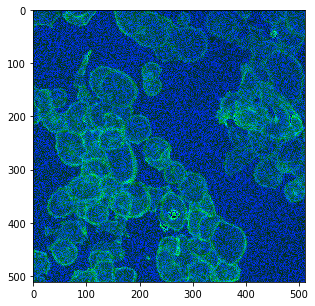

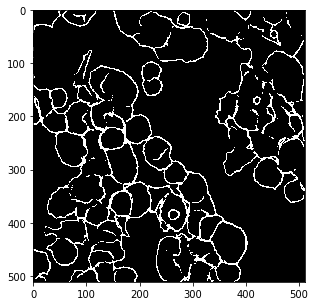

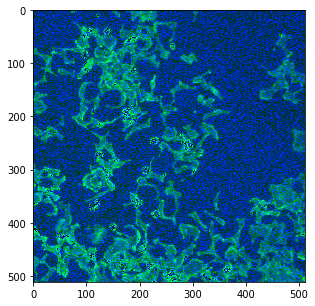

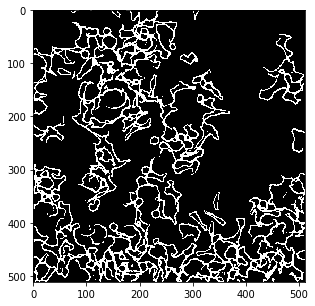

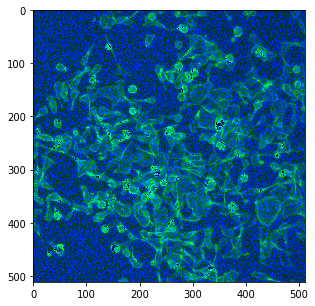

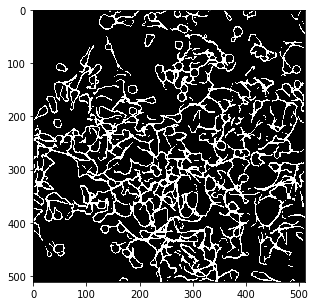

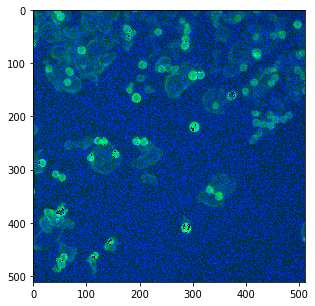

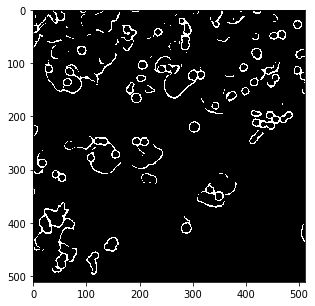

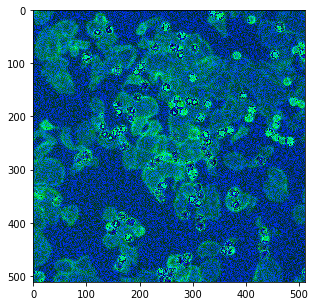

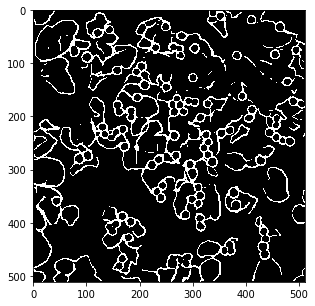

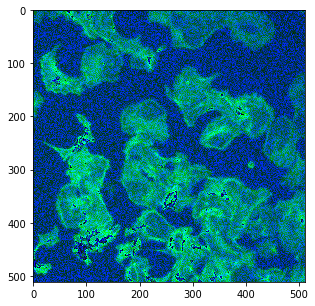

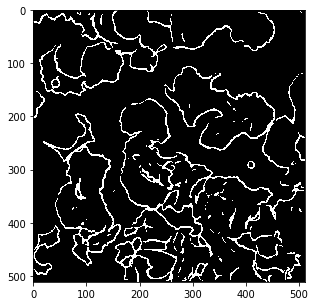

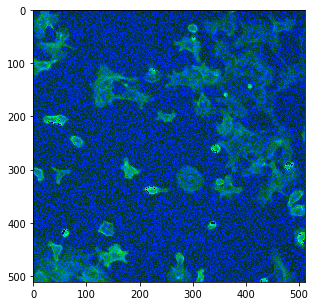

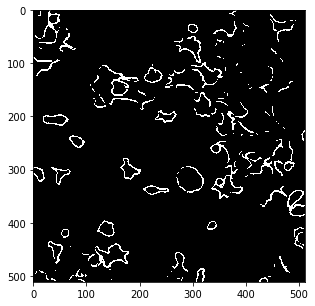

In [43]:
for img_name in os.listdir("BBBC018_v1_images-fixed/test/"):
    arr = np.asarray(Image.open("BBBC018_v1_images-fixed/test/" + img_name)).astype(np.float32) / 255
    plt.figure(figsize=(5, 5))
    plt.imshow(Image.open("BBBC018_v1_images-fixed/test/" + img_name))
    plt.show()
    arr_var = torch.autograd.Variable(torch.FloatTensor(arr.T), requires_grad=False, volatile=True)[None, ...].cuda()
    logits = model(arr_var)
    res = get_mask(logits, 0.8)
    plt.figure(figsize=(5, 5))
    img = (res.data.cpu().numpy()[0].T * 255).astype(np.uint8)
    img_pil = Image.fromarray(img)
    img_pil.save("results/" + img_name + ".png", format="png")
    plt.imshow(img_pil)
    plt.show()